In [12]:
import gymnasium as gym
import tqdm
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        
    def push(self, *args):
        self.memory.append(Transition(*args))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)
    
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions, n_hidden=128):
        super().__init__()
        self.layer1 = nn.Linear(n_observations, n_hidden)
        self.layer2 = nn.Linear(n_hidden, n_hidden)
        self.layer3 = nn.Linear(n_hidden, n_actions)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x
    
class DQNAgent(nn.Module):
    def __init__(self, env, batch_size, gamma, eps_start, eps_end, eps_decay, tau, lr, device, memory_size):
        super().__init__()
        self.env = env
        self.batch_size = batch_size
        self.gamma = gamma
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.tau = tau
        self.device = device
        
        n_actions = env.action_space.n
        state, _ = env.reset()
        n_observations = len(state)

        
        self.policy_net = DQN(n_observations=n_observations, n_actions=n_actions).to(device)
        self.target_net = DQN(n_observations=n_observations, n_actions=n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = torch.optim.AdamW(self.policy_net.parameters(), lr=lr, amsgrad=True)
        
        self.memory = ReplayMemory(memory_size)
        self.steps_done = 0
        self.loss = 0
        self.episode_durations = []
        self.loss_history = []
    
    def select_action(self, state):
        sample=random.random()
        eps = self.eps_end + (self.eps_start - self.eps_end) * math.exp(-1. * self.steps_done / self.eps_decay)
        self.steps_done += 1
        if sample > eps:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, -1) ##
        else:
            return torch.tensor([[self.env.action_space.sample()]], device=self.device, dtype=torch.long) ## 
            
    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return
        transitions = self.memory.sample(self.batch_size)
        batch=Transition(*zip(*transitions))
        
        non_final_mask=torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=self.device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        self.state_action_values = self.policy_net(state_batch).gather(1, action_batch)
        self.next_state_values = torch.zeros(self.batch_size, device=self.device)
        with torch.no_grad():
            self.next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
        self.expected_state_action_values = (self.next_state_values*self.gamma) + reward_batch
        
        criterion = nn.SmoothL1Loss()
        self.loss = criterion(self.state_action_values, self.expected_state_action_values.unsqueeze(1)) ##
        ##self.loss.requires_grad_(True)
        self.loss_history.append(self.loss)
        self.optimizer.zero_grad()
        self.loss.backward()
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()
        
    def train(self, episodes):
        try: 
            assert torch.cuda.is_available()
            num_episodes = episodes
        except:
            print("CUDA Unavailable")
            num_episodes = 50
            
        for _ in tqdm.tqdm(range(num_episodes), ncols=100):
            state, _ = self.env.reset()
            state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            for t in count():
                action = self.select_action(state)
                observation, reward, terminated, truncated, _ = self.env.step(action.item())
                reward = torch.tensor([reward], device=self.device)
                done = terminated or truncated
                if terminated:
                    next_state = None
                else:
                    next_state = torch.tensor(observation, dtype=torch.float32, device=self.device).unsqueeze(0)
                self.memory.push(state, action, next_state, reward)
                state = next_state
                self.optimize_model()
                
                target_net_state_dict = self.target_net.state_dict()
                policy_net_state_dict = self.policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key]*self.tau + target_net_state_dict[key]*(1 - self.tau)
                self.target_net.load_state_dict(target_net_state_dict)
                
                if done:
                    self.episode_durations.append(t + 1)
                    self.plot_duration()
                    break
                
    def savefig(self, root=None):
        durations_t = torch.tensor(self.episode_durations, dtype=torch.float)
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
        plt.title('Result')
        plt.xlabel('Episode')
        plt.ylabel('Duration')
        plt.savefig(root if root is None else 'dqn.png')
        
            
    def plot_duration(self, show_result=False):
        plt.figure(1)
        durations_t = torch.tensor(self.episode_durations, dtype=torch.float)
        if show_result:
            plt.title("Result")
        else:
            plt.clf()
            plt.title("Training")
            plt.xlabel('Episode')
        plt.ylabel('Duration')
        plt.plot(durations_t.numpy())
        if len(durations_t) >= 100:
            means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(99), means))
            plt.plot(means.numpy())
        plt.pause(0.001)  # pause a bit so that plots are updated
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())
                
# if __name__ == '__main__':
#     BATCH_SIZE = 128
#     GAMMA = 0.99
#     EPS_START = 0.9
#     EPS_END = 0.05
#     EPS_DECAY = 1000
#     LR = 1e-4
#     TAU=0.005
#     EPOCHS = 700

#     env = gym.make('CartPole-v1')
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     agent = DQNAgent(env=env, batch_size=BATCH_SIZE, gamma=GAMMA, eps_start=EPS_START, eps_end=EPS_END, 
#                  eps_decay=EPS_DECAY, tau=TAU, lr=LR, device=device, memory_size=10000)
#     agent.train(EPOCHS)
#     agent.savefig()

In [1]:
import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt
import torch

from dqn import DQNAgent

In [21]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
LR = 1e-4
TAU=0.005
EPOCHS = 500

env = gym.make('CartPole-v1')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
agent = DQNAgent(env=env, batch_size=BATCH_SIZE, gamma=GAMMA, eps_start=EPS_START, eps_end=EPS_END, 
                 eps_decay=EPS_DECAY, tau=TAU, lr=LR, device=device, memory_size=10000)

In [23]:
agent.train(EPOCHS)

 88%|████████████████████████████████████████████████████       | 441/500 [1:26:55<25:45, 26.20s/it]

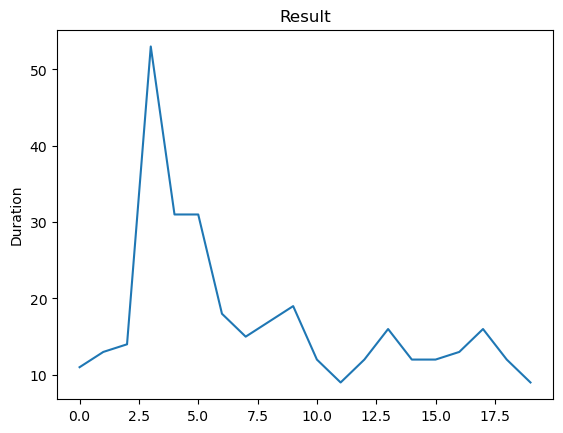

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
agent.plot_duration(show_result=True)

In [7]:
agent.loss

tensor(0.4996, device='cuda:0', requires_grad=True)

In [14]:
criterion = torch.nn.SmoothL1Loss()

In [17]:
criterion(agent.state_action_values.flatten(), agent.next_state_values)

tensor(0.0001, device='cuda:0', grad_fn=<SmoothL1LossBackward0>)

In [12]:
(agent.state_action_values.flatten()-agent.next_state_values).abs()

tensor([0.0041, 0.0046, 0.0070, 0.0041, 0.0346, 0.0042, 0.0056, 0.0067, 0.0056,
        0.0058, 0.0010, 0.0165, 0.0041, 0.0124, 0.0256, 0.0366, 0.0066, 0.0193,
        0.0098, 0.0115, 0.0084, 0.0100, 0.0066, 0.0270, 0.0060, 0.0038, 0.0146,
        0.0123, 0.0254, 0.0011, 0.0089, 0.0029, 0.0003, 0.0141, 0.0051, 0.0052,
        0.0035, 0.0059, 0.0071, 0.0023, 0.0124, 0.0055, 0.0012, 0.0308, 0.0021,
        0.0055, 0.0017, 0.0062, 0.0112, 0.0119, 0.0162, 0.0000, 0.0356, 0.0089,
        0.0239, 0.0045, 0.0065, 0.0136, 0.0039, 0.0065, 0.0050, 0.0283, 0.0080,
        0.0047, 0.0028, 0.0041, 0.0126, 0.0015, 0.0110, 0.0054, 0.0035, 0.0043,
        0.0289, 0.0128, 0.0126, 0.0727, 0.0036, 0.0375, 0.0409, 0.0077, 0.0010,
        0.0019, 0.0120, 0.0036, 0.0138, 0.0310, 0.0054, 0.0028, 0.0053, 0.0053,
        0.0145, 0.0003, 0.0062, 0.0117, 0.0064, 0.0056, 0.0378, 0.0044, 0.0027,
        0.0006, 0.0044, 0.0025, 0.0112, 0.0115, 0.0031, 0.0216, 0.0061, 0.0119,
        0.0029, 0.0456, 0.0031, 0.0119, 

In [7]:
agent.next_state_values

tensor([0.0207, 0.0404, 0.0324, 0.0231, 0.0000, 0.0135, 0.0139, 0.0065, 0.0306,
        0.0286, 0.0237, 0.0165, 0.0044, 0.0257, 0.0256, 0.0366, 0.0199, 0.0575,
        0.0161, 0.0317, 0.0320, 0.0582, 0.0317, 0.0270, 0.0316, 0.0383, 0.0386,
        0.0599, 0.0000, 0.0313, 0.0462, 0.0323, 0.0012, 0.0327, 0.0264, 0.0278,
        0.0378, 0.0280, 0.0295, 0.0782, 0.0470, 0.0312, 0.0184, 0.0308, 0.0278,
        0.0258, 0.0241, 0.0222, 0.0241, 0.0566, 0.0424, 0.0000, 0.0356, 0.0000,
        0.0239, 0.0362, 0.0274, 0.0000, 0.0169, 0.0315, 0.0725, 0.0283, 0.0247,
        0.0722, 0.0405, 0.0255, 0.0350, 0.0096, 0.0456, 0.0287, 0.0375, 0.0108,
        0.0289, 0.0323, 0.0263, 0.0000, 0.0393, 0.0375, 0.0409, 0.0464, 0.0108,
        0.0302, 0.0603, 0.0254, 0.0528, 0.0310, 0.0317, 0.0805, 0.0264, 0.0296,
        0.0401, 0.0330, 0.0300, 0.0487, 0.0273, 0.0305, 0.0378, 0.0321, 0.0190,
        0.0329, 0.0000, 0.0236, 0.0432, 0.0156, 0.0239, 0.0323, 0.0630, 0.0464,
        0.0144, 0.0000, 0.0132, 0.0587, 

In [6]:
agent.loss_history

[0.4996747374534607,
 0.49967464804649353,
 0.4996754825115204,
 0.49967533349990845,
 0.49967432022094727,
 0.4996761381626129,
 0.4996741712093353,
 0.49967432022094727,
 0.49967649579048157,
 0.4996744394302368,
 0.49967628717422485,
 0.4996839165687561,
 0.49967867136001587,
 0.49967822432518005,
 0.49967944622039795,
 0.4996815621852875,
 0.4996796250343323,
 0.49968481063842773,
 0.49967703223228455,
 0.4996819794178009,
 0.4996751844882965,
 0.49967774748802185,
 0.4996773302555084,
 0.4996800422668457,
 0.4996805787086487,
 0.499683141708374,
 0.49968475103378296,
 0.4996780753135681,
 0.4996829628944397,
 0.49967557191848755,
 0.49967387318611145,
 0.4996660351753235,
 0.4996621310710907,
 0.4996727705001831,
 0.49966394901275635,
 0.4996646046638489,
 0.4996710419654846,
 0.49966493248939514,
 0.4996638894081116,
 0.4996641278266907,
 0.49967873096466064,
 0.49966663122177124,
 0.49966686964035034,
 0.49966639280319214,
 0.4996718168258667,
 0.4996653199195862,
 0.49966180324